<a href="https://www.kaggle.com/code/agastyapatel/comparing-different-models-types?scriptVersionId=158058758" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
%%capture 
!pip install nbdev

# Goal
Notebook tries to compare few model training, explore different training types. We are using high level api 'FastAI' for this purpose. This notebook is based on the quickstart tutorials and tries to explore different models and some training options. Good read for beginners.

## Computer Vision
PET CLASSIFIER using [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/)
### About dataset
- Dataset contains images of cats and dogs
- Contains data of 37 breeds

**Annotation Methods Used**
- .trimaps used for providing hints for separation between foreground and background
- list which provide annotation with index based on categories and filenames
- Name of the file (If Title case then cat else dog)

In [3]:
# Importing Dependency
from fastai.vision.all import *
petPath = untar_data(URLs.PETS)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
print('BasePath: ',petPath,'\n', petPath.ls())
import os
os.path.exists(petPath/'images')

BasePath:  /root/.fastai/data/oxford-iiit-pet 
 [Path('/root/.fastai/data/oxford-iiit-pet/images'), Path('/root/.fastai/data/oxford-iiit-pet/annotations')]


True

In [5]:
petfiles = get_image_files(petPath/'images')
print(len(petfiles))   #Number of files
petfiles

7390


(#7390) [Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_115.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_18.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_157.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_28.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_6.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_79.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_128.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_265.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_182.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_89.jpg')...]

In [6]:
def label_function(f): return 'Cat' if f[0].isupper() else 'Dog'

petDls = ImageDataLoaders.from_name_func(petPath,
                                      petfiles,
                                      label_function,
                                      seed = 0.42,
                                      valid_pct = 0.2,
                                      item_tfms=Resize(224))
petDls

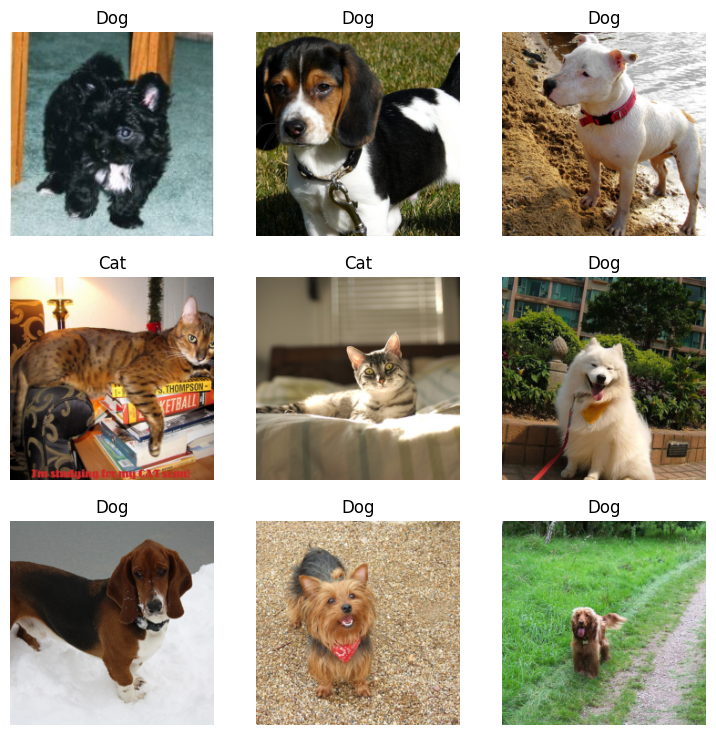

In [7]:
petDls.show_batch()

## Fine Tuning
- Resnet34

In [8]:
petLearner34 = vision_learner(petDls, resnet34, metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 213MB/s] 


In [9]:
petLearner34.fine_tune(2)

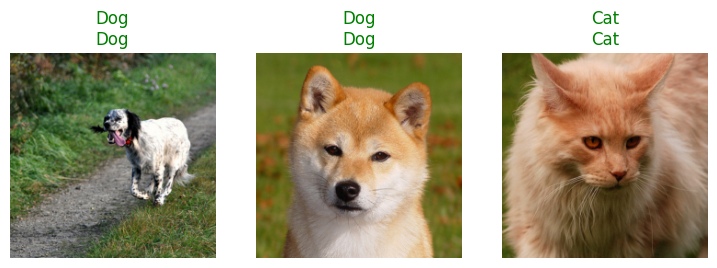

In [10]:
doc(petLearner34.show_results)
petLearner34.show_results(max_n = 3)

### Comparing other pretrained model
We will be using resnet18 and convnext for comparision

In [11]:
!pip show timm

Name: timm
Version: 0.9.12
Summary: PyTorch Image Models
Home-page: https://github.com/huggingface/pytorch-image-models
Author: Ross Wightman
Author-email: ross@huggingface.co
License: 
Location: /opt/conda/lib/python3.10/site-packages
Requires: huggingface-hub, pyyaml, safetensors, torch, torchvision
Required-by: 


In [12]:
import timm
timm.list_models('convnext*') # Prints available model

['convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

In [18]:
petLearner18 = vision_learner(petDls, resnet18, metrics = error_rate)
petLearner18.fine_tune(2)

In [14]:
petLearnerCon = vision_learner(petDls, 'convnext_nano', metrics = error_rate)
petLearnerCon.fine_tune(2)

model.safetensors:   0%|          | 0.00/62.4M [00:00<?, ?B/s]

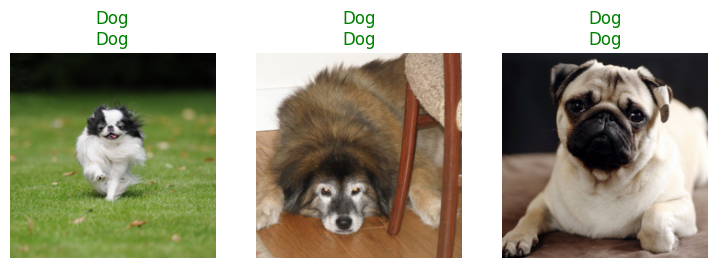

In [15]:
petLearnerCon.show_results(max_n = 3)

### Comparision


In [16]:
# Checking if the fine tuning performance history has been recorded
for learners in [petLearner34, petLearner18, petLearnerCon]:
    for item in learners.recorder.values:
        print(item)

[0.018796591088175774, 0.015625]
[0.05925074219703674, 0.015918686985969543, 0.005412719678133726]
[0.03182956948876381, 0.01259362418204546, 0.00405954010784626]
[8.660268213134259e-05, 0.0]


Compared different models
- Resnet 34 
- Resnet 18
- ConvNext_Nano

Outcome:
While considering model, following things can be a factor which can be considered : 
- size of the model: Whether the model will fit in gpu while fine tuning?
- Smaller model or less layered Nueral network will be quicker to train but accuracy will be compromised.
- In circumstances where accuracy is primary factor and predication are made extremely critical situation; then more accurate model should be preferred.

## Train Breed Identifier
We will be using from_name_re (identifies label from path using re)

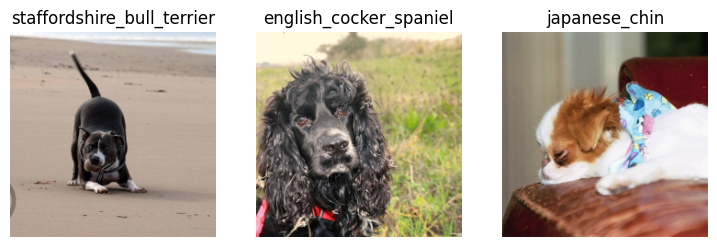

In [36]:
re = r'^(.*)_\d+.jpg'
breedDls = ImageDataLoaders.from_name_re(petPath,
                              petfiles,
                              re, item_tfms = Resize(224))
breedDls.show_batch(max_n = 3)

In [38]:
breedLearner = vision_learner(breedDls, resnet34, metrics = error_rate)       

In [39]:
breedLearner.fine_tune(5)

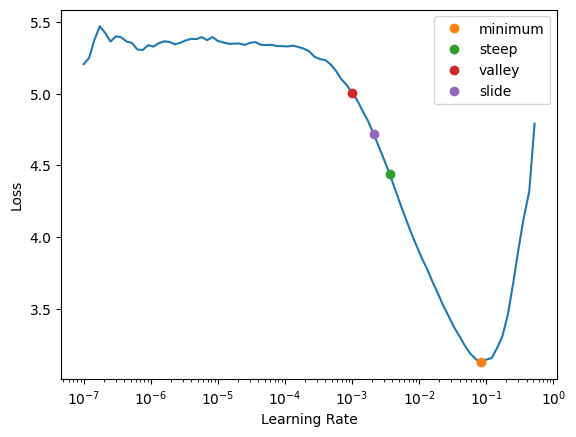

In [49]:
#Breed Learner2 Contains the learning rate suggested by learning rate finder
breedDls = ImageDataLoaders.from_name_re(petPath,
                              petfiles,
                              re, item_tfms = Resize(224))
breedLearner2 = vision_learner(breedDls, resnet34, metrics = error_rate)
breed_lr = breedLearner2.lr_find(suggest_funcs=(minimum, steep, valley, slide)) 

In [50]:
breedLearner2.fine_tune(5, breed_lr.steep)

### Resnet34 with Learning Rate Performance
Resnet34 with good learning rate is more accurate when trained for same epochs. Due to some randomness sometimes Model fine tuned with explicitly supplied LR might be little poor or almost the same of regular fine tuned model. 
It might take one or two tries to get good LR but kaggle might change the result while saving the nb.
I'm attaching a comparision chart anyhow.

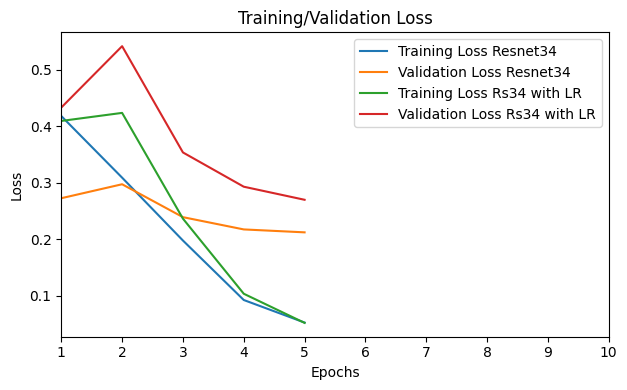

In [51]:
def plot_training_history(learners, labels):
    # Extract training loss, validation loss, and error rate from training history
    train_loss, valid_loss, error_rate = [], [], []
    for i, learner in enumerate(learners):
        train_loss.append([item[0] for item in learner.recorder.values])
        valid_loss.append([item[1] for item in learner.recorder.values])
        error_rate.append([1 - item[2] for item in learner.recorder.values])

    # Plotting
    epochs = range(1, len(train_loss[0]) + 1)
    plt.figure(figsize=(12, 4))

    # Plotting training and validation loss
    plt.subplot(1, 2, 1)
    for i in range(len(labels)):
        plt.plot(epochs, train_loss[i], label=f'Training Loss {labels[i]}')
        plt.plot(epochs, valid_loss[i], label=f'Validation Loss {labels[i]}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training/Validation Loss')
    plt.xlim(1, 10)
    plt.legend()

#     # Plotting error rate
#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, error_rate[:10], label=f'Accuracy Rate ({label})')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.title(label + ': Accuracy')
#     plt.xlim(1, 10)
#     plt.legend()

    plt.tight_layout()
    plt.show()
    
plot_training_history([breedLearner, breedLearner2], ['Resnet34', 'Rs34 with LR'])

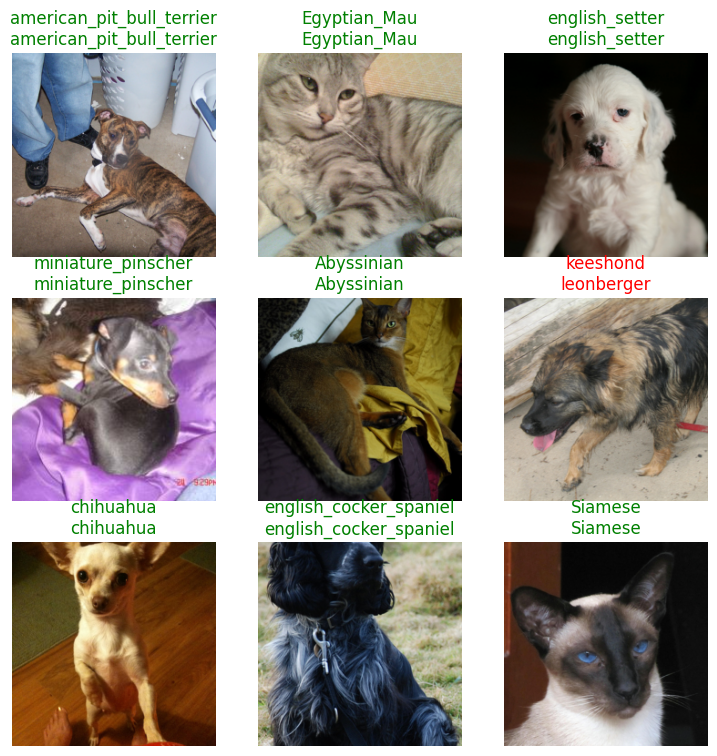

In [52]:
breedLearner2.show_results()

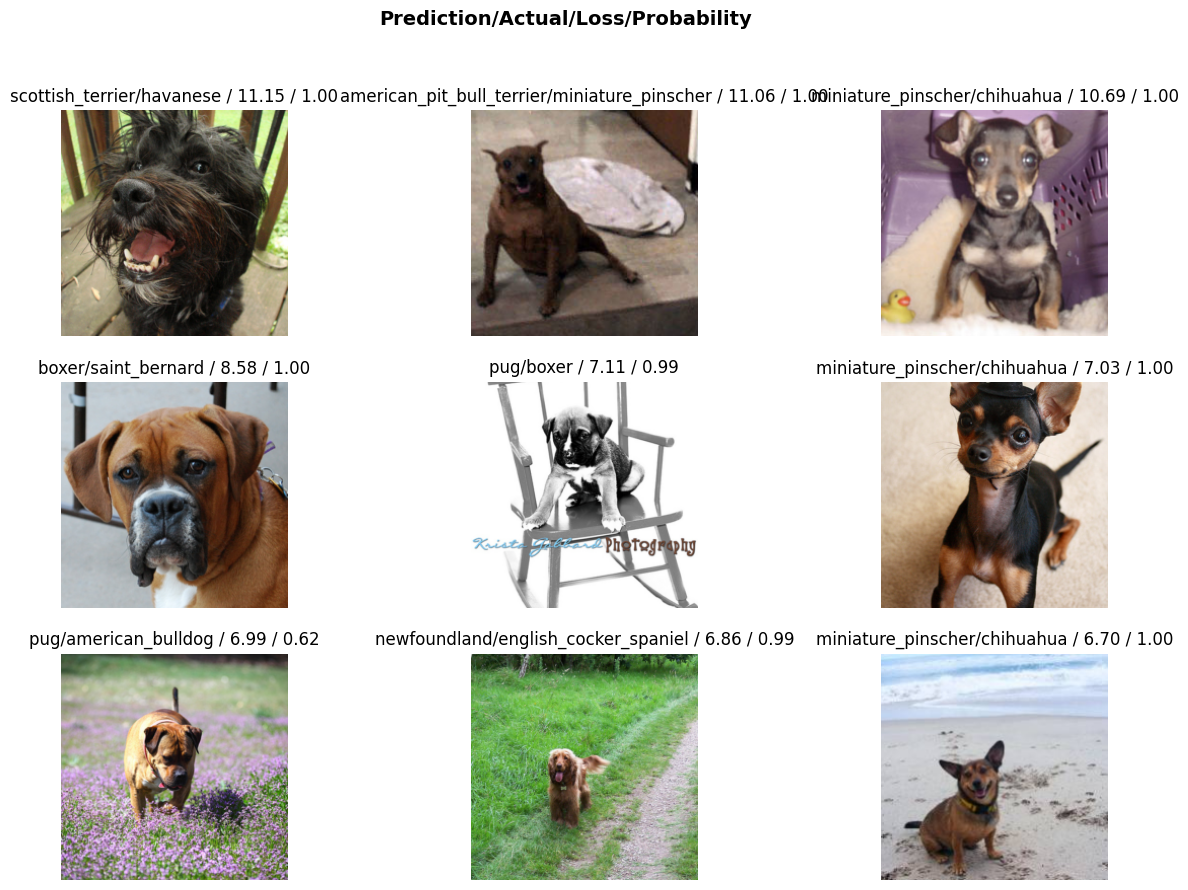

In [53]:
interp = Interpretation.from_learner(breedLearner2)
interp.plot_top_losses(9, figsize = (15,10))

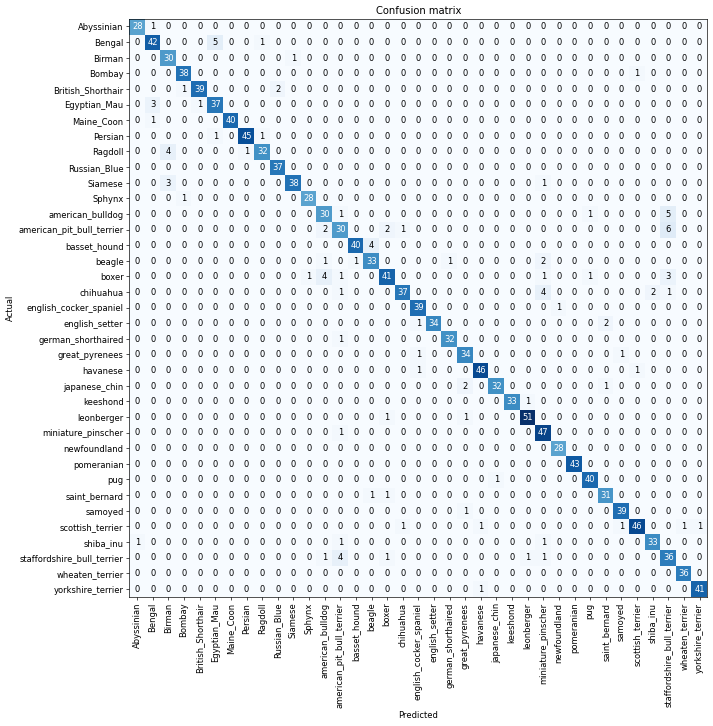

In [54]:
classInterp = ClassificationInterpretation.from_learner(breedLearner2)
classInterp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## Single Label Classification
Using Datablock API. These type of classification is used to make single prediction ie, the class of the object.

In [ ]:
## DataBlock => DataLoaders => Fine Tuning
# pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
#                 get_items = get_image_files,
#                 splitter = RandomSplitter(),
#                 get_y = using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
#                 item_tfms = Resize(460),
#                 batch_tfms = aug_transforms(size=224))
# dls2 = pets.dataloaders(untar_data(URLs.PETS)/'images')

In [ ]:
# dls2.show_batch(max_n = 9)

## Multi-Label Classification
Classifier for not only guessing the class of the object but also to draw an bounding box around the object recognized.
### About Dataset
Name: Pascal 2007
[Reference](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/)\
Goal: To guess the class of the object and also to draw a visual bounding box around the object.
Classes Determined:
- Person: person
- Animal: bird, cat, cow, dog, horse, sheep
- Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
- Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

In [55]:
# Downloading data set
mlcPath = untar_data(URLs.PASCAL_2007, base='/kaggle/temp/')
print(mlcPath/'train.csv')
mlcPath.ls()

/root/.fastai/data/pascal_2007/train.csv


(#8) [Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/train.json')]

In [56]:
pascalDf = pd.read_csv(mlcPath/'train.csv')
print(type(pascalDf))
pascalDf

<class 'pandas.core.frame.DataFrame'>


fname          labels  is_valid
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]

In [57]:
pascalDls = ImageDataLoaders.from_df(pascalDf, mlcPath, folder='train', valid_col='is_valid', label_delim=' ',
                               item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

/opt/conda/lib/python3.10/site-packages/fastai/data/transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


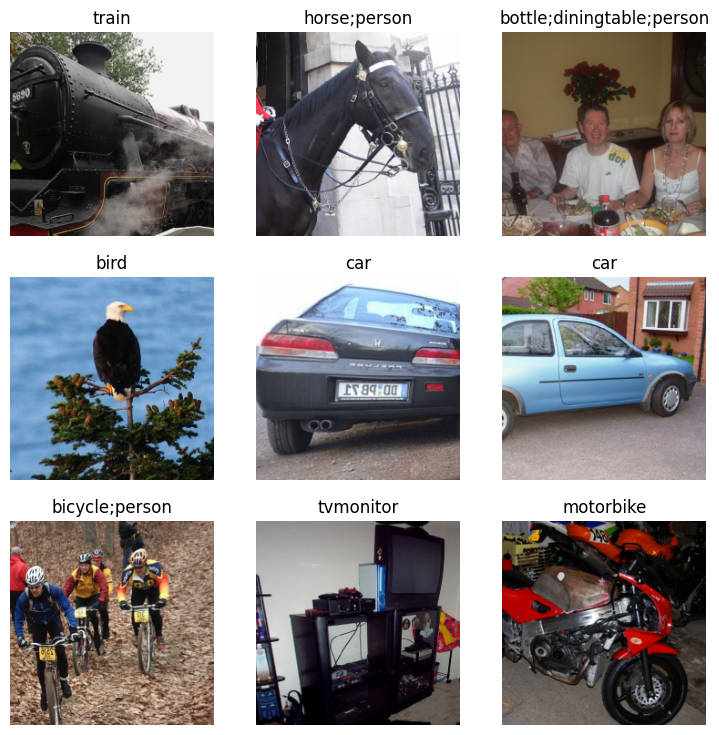

In [58]:
pascalDls.show_batch()

In [60]:
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'
mlcLearner = vision_learner(pascalDls, resnet50, metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 230MB/s] 


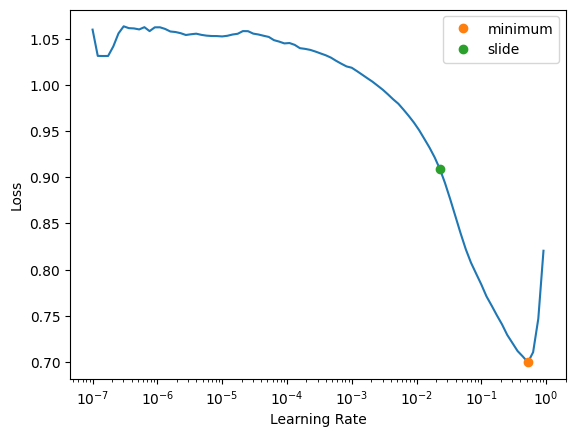

In [61]:
mcl_lr = mlcLearner.lr_find(suggest_funcs = (minimum, slide))

In [62]:
mlcLearner.fine_tune(2, mcl_lr.slide)

/opt/conda/lib/python3.10/site-packages/fastai/data/transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
/opt/conda/lib/python3.10/site-packages/fastai/data/transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
/opt/conda/lib/python3.10/site-packages/fastai/data/transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels 

In [63]:
mlcLearner.predict(mlcPath/'train/000005.jpg')

((#1) ['chair'],
 tensor([False, False, False, False, False, False, False, False,  True, False,
         False, False, False, False, False, False, False, False, False, False]),
 tensor([4.9180e-04, 3.1579e-03, 4.7851e-04, 2.4034e-04, 1.1271e-02, 8.6418e-03,
         3.2377e-03, 3.0003e-03, 8.7865e-01, 1.5411e-03, 2.2386e-01, 7.2953e-03,
         7.9520e-04, 3.6285e-04, 9.2236e-02, 8.0669e-02, 2.6766e-04, 1.8466e-01,
         1.5269e-04, 4.5502e-01]))

/opt/conda/lib/python3.10/site-packages/fastai/data/transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
/opt/conda/lib/python3.10/site-packages/fastai/data/transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
/opt/conda/lib/python3.10/site-packages/fastai/data/transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels 

/opt/conda/lib/python3.10/site-packages/fastai/data/transforms.py:212: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


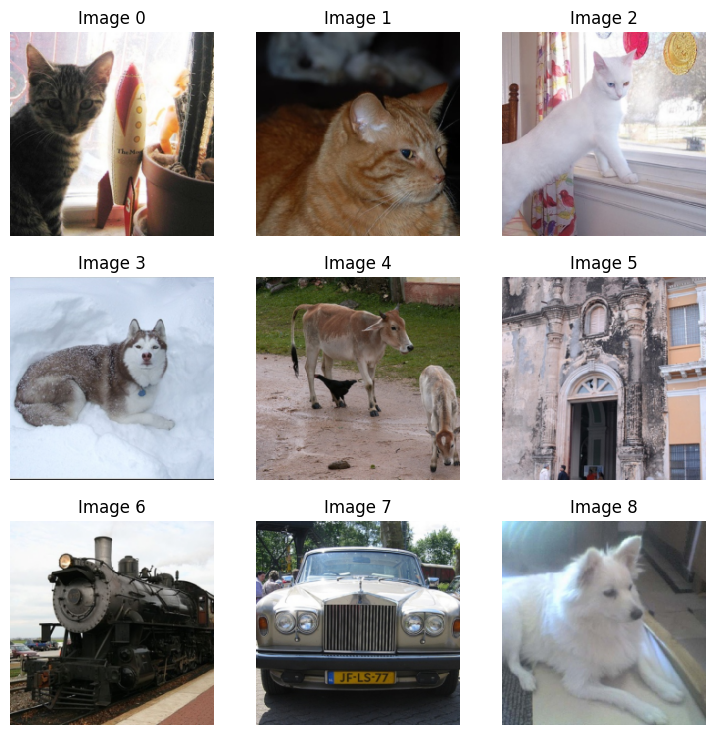

In [65]:
interp = Interpretation.from_learner(mlcLearner)
interp.plot_top_losses(9)

# Segmentation Model


In [66]:
camPath = untar_data(URLs.CAMVID_TINY)
camPath.ls()

(#3) [Path('/root/.fastai/data/camvid_tiny/images'),Path('/root/.fastai/data/camvid_tiny/codes.txt'),Path('/root/.fastai/data/camvid_tiny/labels')]

In [68]:
codes = np.loadtxt(camPath/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [73]:
fnames = get_image_files(camPath/"images")
fnames[0]

Path('/root/.fastai/data/camvid_tiny/images/0001TP_006750.png')

In [75]:
def label_func(fn): return camPath/"labels"/f"{fn.stem}_P{fn.suffix}"

In [79]:
segDls = SegmentationDataLoaders.from_label_func(
    camPath, bs=8, fnames = fnames, label_func = label_func, codes = codes
)

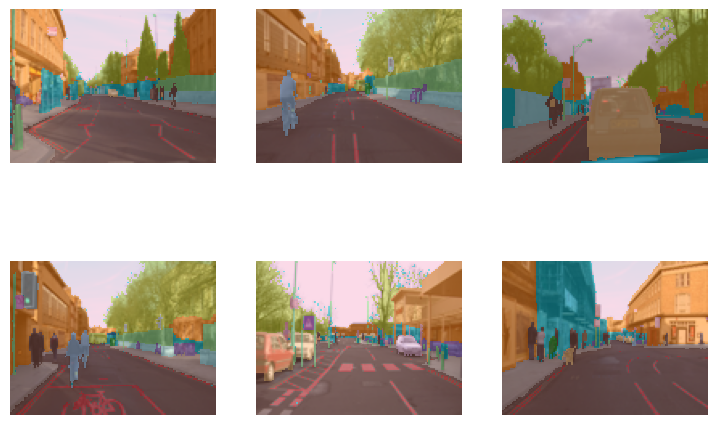

In [80]:
segDls.show_batch(max_n=6)

In [86]:
segLearn = unet_learner(segDls, resnet34)
segLearn.fine_tune(6)

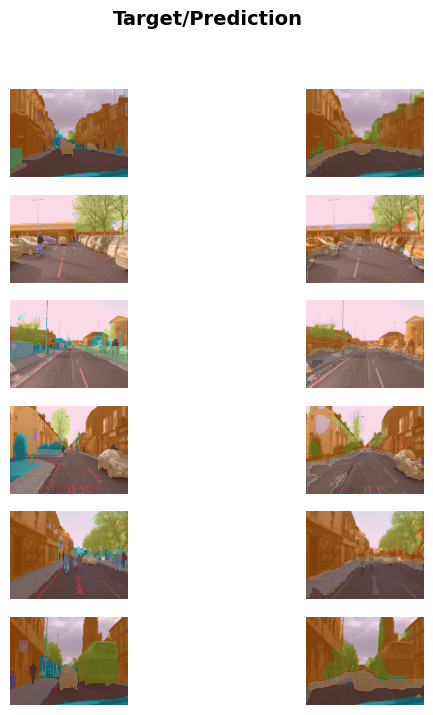

In [88]:
segLearn.show_results(max_n=6, figsize=(7,8))

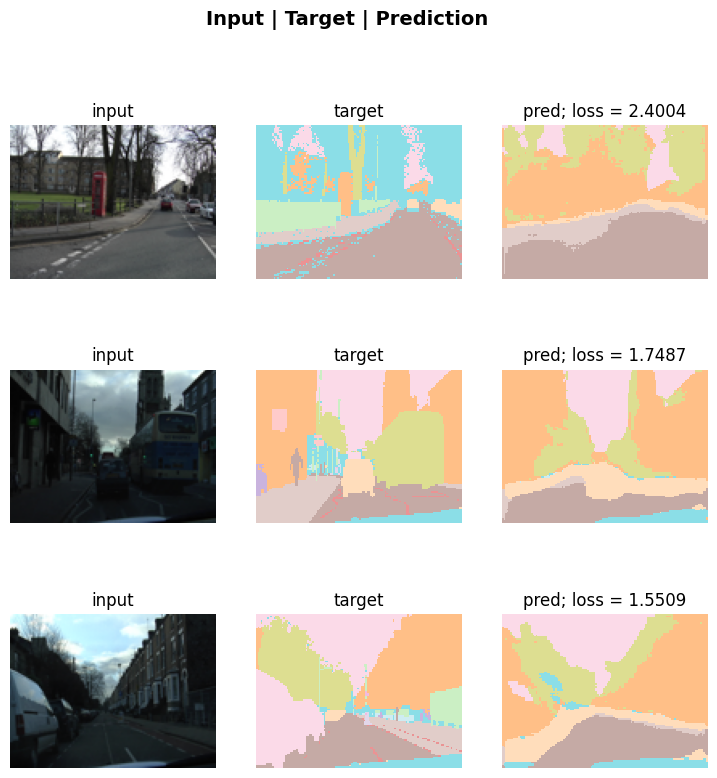

In [91]:
interp = SegmentationInterpretation.from_learner(segLearn)
interp.plot_top_losses(k=3)